# Australian Geoscience Datacube API
Generate statistics over a range of time, or by seasons.

In [2]:
%matplotlib inline
from pprint import pprint
import numpy as np
import xarray.ufuncs

import sys
sys.path.insert(0,"/g/data1/u46/fxz547/Githubz/agdc-v2")

import datacube.api
from datacube.api import API
from datacube.index import index_connect
from datacube.config import LocalConfig


In [4]:

# which datacube connection ?
# it's up to you to use this hack

force_prod = True    # False

if force_prod:
    prod_config = LocalConfig.find(['/g/data/v10/public/modules/agdc-py2-prod/1.0.2/datacube.conf'])
    prod_index = index_connect(prod_config, application_name='api-WOfS-dev')
    dc = API(prod_index)
else:
    dc = API(application_name='api-WOfS-dev')

In [5]:
data = dc.get_data_array(platform='LANDSAT_5', product='nbar', y=(-34.95,-35.05), x=(148.95,149.05))
data

<xarray.DataArray u'ls5_nbar_albers' (variable: 6, time: 88, y: 490, x: 420)>
dask.array<concate..., shape=(6, 88, 490, 420), dtype=float64, chunksize=(1, 88, 490, 420)>
Coordinates:
  * time      (time) datetime64[ns] 2006-01-25T23:40:22.225006 ...
  * y         (y) float64 -3.919e+06 -3.919e+06 -3.919e+06 -3.919e+06 ...
  * x         (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...
  * variable  (variable) <U6 u'band_1' u'band_2' u'band_3' u'band_4' ...

In [7]:
data = data.chunk({'time':182})
data.chunks

((1, 1, 1, 1, 1, 1), (88,), (490,), (420,))

In [8]:
nan_sum = data.sum(dim='time', skipna=True)

In [9]:
print nan_sum

<xarray.DataArray u'ls5_nbar_albers' (variable: 6, y: 490, x: 420)>
dask.array<sum-agg..., shape=(6, 490, 420), dtype=float64, chunksize=(1, 490, 420)>
Coordinates:
  * y         (y) float64 -3.919e+06 -3.919e+06 -3.919e+06 -3.919e+06 ...
  * x         (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...
  * variable  (variable) <U6 u'band_1' u'band_2' u'band_3' u'band_4' ...


In [10]:
vld_obs = xarray.ufuncs.isfinite(data).sum(dim='time')

In [11]:
mean = nan_sum / vld_obs

In [12]:
residuals = data - mean

In [13]:
res_sq = residuals**2

### Masking with Pixel Quality Data

In [17]:
pq = dc.get_data_array(platform='LANDSAT_5', product='pqa', y=(-34.95,-35.05), x=(148.95,149.05), set_nan=False)
pq = pq.squeeze('variable')
pq

<xarray.DataArray u'ls5_pq_albers' (time: 88, y: 490, x: 420)>
dask.array<getitem..., shape=(88, 490, 420), dtype=int16, chunksize=(1, 490, 420)>
Coordinates:
  * time      (time) datetime64[ns] 2006-01-25T23:40:22.225006 ...
  * y         (y) float64 -3.919e+06 -3.919e+06 -3.919e+06 -3.919e+06 ...
  * x         (x) float64 1.538e+06 1.538e+06 1.538e+06 1.538e+06 1.538e+06 ...
    variable  <U12 u'pixelquality'

In [18]:
cloud_free = (pq^16383).astype('bool')

### Seasonal statistics
The `xarray.DataArray` objects provide Pandas-style indexing, including `groupby`.

In [19]:
red = data.sel(variable='band_3').where(cloud_free)
nir = data.sel(variable='band_4').where(cloud_free)

In [20]:
ndvi = (nir - red) / (nir + red)
ndvi_seasons = ndvi.groupby('time.season')

In [21]:
ndvi_seasonal_mean = ndvi_seasons.mean('time', skipna=True)

/g/data1/u46/fxz547/anaconda2/lib/python2.7/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/g/data1/u46/fxz547/anaconda2/lib/python2.7/site-packages/dask/async.py:246: RuntimeWarning: invalid value encountered in divide
  return func(*args2)


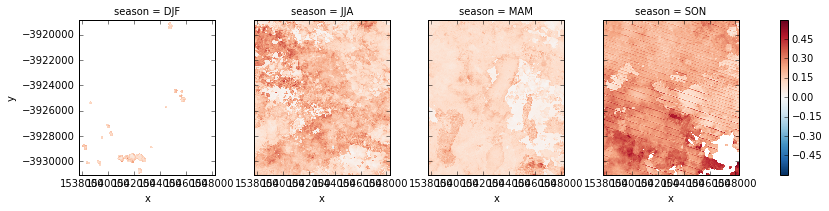

In [22]:
ndvi_seasonal_mean.plot(col='season')